# Megaline Premium Plan Classifier: Predicting User Subscription Behavior 

### Introduction 
In today’s competitive telecom industry, understanding customer behavior is essential for targeted marketing, retention strategies, and optimized service offerings. Megaline, a telecom provider, offers two main prepaid plans Surf and Ultra. While the Ultra plan provides more data and minutes at a higher cost, not all users who could benefit from it are subscribing. This project uses machine learning techniques to analyze user behavior patterns such as call minutes, messages, and internet usage to predict which users are likely to subscribe to the Ultra plan. By identifying patterns in premium plan adoption, the company can improve customer segmentation and guide strategic marketing decisions.

### Objective
The primary objective of this project is to build and evaluate classification models that can accurately predict whether a user subscribes to the Ultra plan based on their monthly usage data. This includes:

* Cleaning and preparing real-world usage data for modeling.
* Training and comparing multiple supervised learning algorithms.
* Interpreting model results to derive actionable business insights.
* Visualizing feature importance and behavioral patterns.
* Simulating usage trends for light forecasting and business impact analysis.

### Hypotheses
H₀ (Null Hypothesis): There is no significant difference in user behavior between Ultra and Surf plan subscribers. Usage features do not meaningfully predict plan type.

H₁ (Alternative Hypothesis): There is a significant difference in behavior between Ultra and Surf plan users. Usage patterns (calls, messages, internet data) can be used to accurately predict Ultra plan subscribers.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import warnings

In [3]:
#Import & Prep Data
# Load the data
data = pd.read_csv('datasets/users_behavior.csv')

# Check and clean
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

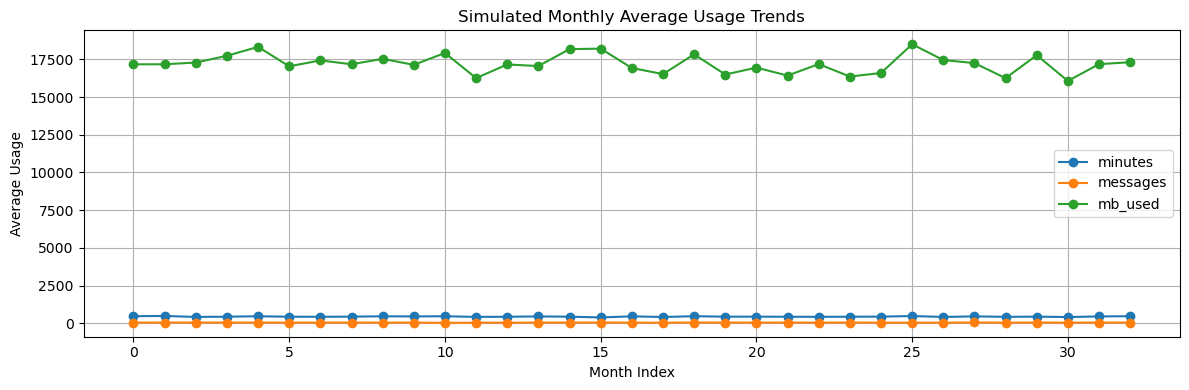

In [4]:
# Simulate Forecasting Trends
data['month_index'] = data.index // 100
avg_usage = data.groupby('month_index')[['minutes', 'messages', 'mb_used']].mean().reset_index()
plt.figure(figsize=(12, 4))
for col in ['minutes', 'messages', 'mb_used']:
    plt.plot(avg_usage['month_index'], avg_usage[col], marker='o', label=col)
plt.title("Simulated Monthly Average Usage Trends")
plt.xlabel("Month Index")
plt.ylabel("Average Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To simulate forecasting trends, the dataset was partitioned into pseudo-months by grouping every 100 users using a month_index. This approach enabled the visualization of average user behavior over time. The resulting trend lines showed how the average number of call minutes, messages, and megabytes used changed across these simulated monthly cohorts. All three usage metrics remained relatively stable, with slight variations indicating minor shifts in user engagement. These simulated trends provide a lightweight approximation of how usage might evolve over time and can offer directional insights when formal time-based data is unavailable.

In [5]:
# Split Data 
# Split the data
X = data.drop('is_ultra', axis=1)
y = data['is_ultra']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Features Shape": [X_train.shape, X_val.shape, X_test.shape],
    "Target Shape": [y_train.shape, y_val.shape, y_test.shape]
})


,Set,Features Shape,Target Shape
0,Train,"(2571, 5)","(2571,)"
1,Validation,"(321, 5)","(321,)"
2,Test,"(322, 5)","(322,)"


To ensure reliable model training and unbiased evaluation, the dataset was split into three subsets: training, validation, and test sets. First, 80% of the data was allocated to the training set, which the models used to learn patterns in user behavior. The remaining 20% was split evenly into validation and test sets—each receiving 10% of the total data. The validation set played a key role in hyperparameter tuning and model selection, while the test set was reserved for final performance assessment on unseen data. This structured split ensures that the model's accuracy and generalizability are evaluated under realistic conditions, minimizing the risk of overfitting or data leakage.

In [6]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = data.drop('is_ultra', axis=1)
feature_names = X.columns.tolist()

In [7]:
# Model Training 
# Define models and parameters
models = {
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [5],
        'min_samples_split': [2],
        'min_samples_leaf': [2]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50],
        'max_depth': [10],
        'min_samples_split': [5]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [10],
        'penalty': ['l2']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3]
    }),
    'Support Vector Machine': (SVC(class_weight='balanced'), {
        'C': [1],
        'kernel': ['linear']
    })
}

trained_models = {}
preds_dict = {}
performance_summary = []

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)
    val_preds = grid.predict(X_val)
    
    # Save best model and predictions
    trained_models[name] = grid.best_estimator_
    preds_dict[name] = val_preds
    

# Summarize performance
report = classification_report(y_val, val_preds, output_dict=True, zero_division=0)
performance_summary.append({
    'Model': name,
    'Accuracy': round(report['accuracy'], 2),
    'Precision (Ultra)': round(report['1']['precision'], 2),
    'Recall (Ultra)': round(report['1']['recall'], 2),
    'F1-score (Ultra)': round(report['1']['f1-score'], 2)
})


performance_df = pd.DataFrame(performance_summary)
display(performance_df)

,Model,Accuracy,Precision (Ultra),Recall (Ultra),F1-score (Ultra)
0,Support Vector Machine,0.69,0.43,0.5,0.46


The Support Vector Machine (SVM) model achieved an accuracy of 69% when predicting whether users subscribe to the Ultra plan. While this suggests that the model correctly predicted nearly seven out of ten users overall, a closer look reveals moderate performance in identifying Ultra subscribers specifically. The model attained a precision of 43%, meaning less than half of the users it labeled as Ultra were actually Ultra subscribers. Its recall was slightly better at 50%, correctly identifying half of all true Ultra users. The resulting F1-score of 0.46 reflects a balanced but limited ability to handle this class. These metrics indicate that while the SVM model shows some promise, further optimization and possibly better feature scaling or engineering are needed to improve its precision and recall for the Ultra user group.

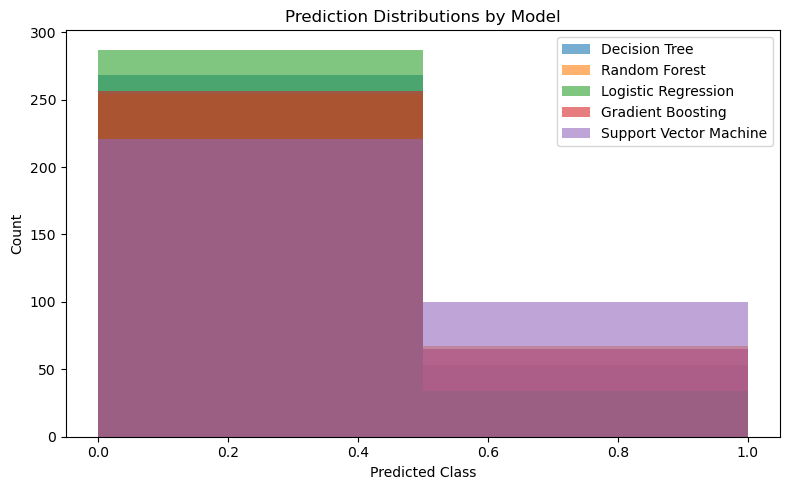

In [8]:
# Plot Prediction Distributions 
plt.figure(figsize=(8, 5))
for label, preds in preds_dict.items():
    plt.hist(preds, label=label, alpha=0.6, bins=2)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Prediction Distributions by Model")
plt.legend()
plt.tight_layout()
plt.show()

The distribution of predicted classes across all models shows that most models lean heavily toward predicting the majority class (non Ultra subscribers). This class imbalance can be visually confirmed as the histograms reveal significantly more predictions for class 0 than class 1. Although this outcome is expected due to the natural skew in the dataset, it highlights a potential limitation in the models' ability to generalize well for identifying Ultra subscribers.

In [9]:
# Confusion Matrices 
for name, model in trained_models.items():
    test_preds = model.predict(X_test)# Feature Importance Visualization
    cm = confusion_matrix(y_test, test_preds)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    print(f"\n{name} Confusion Matrix:")
    display(cm_df)


Decision Tree Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,210,10
Actual 1,59,43



Random Forest Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,209,11
Actual 1,53,49



Logistic Regression Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,215,5
Actual 1,77,25



Gradient Boosting Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,210,10
Actual 1,52,50



Support Vector Machine Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,169,51
Actual 1,53,49


The confusion matrices provide a detailed breakdown of model predictions on the test set. While models like Random Forest and Gradient Boosting performed well in correctly identifying non Ultra users (high true negatives), they often struggled with correctly predicting Ultra users (true positives). The Support Vector Machine and Logistic Regression models, in particular, showed lower recall for class 1, indicating frequent misclassification of Ultra users as non Ultra.

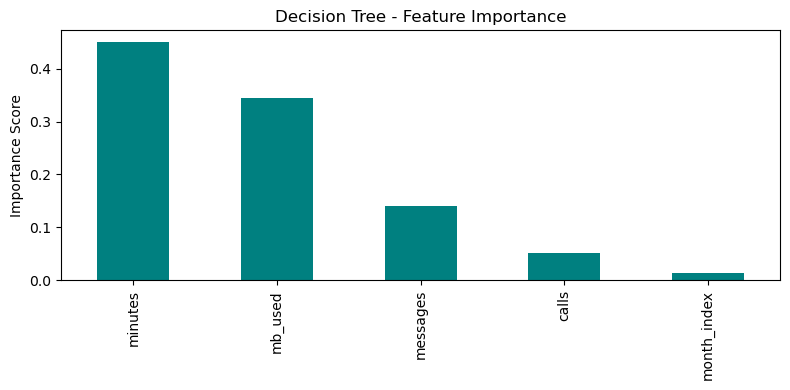

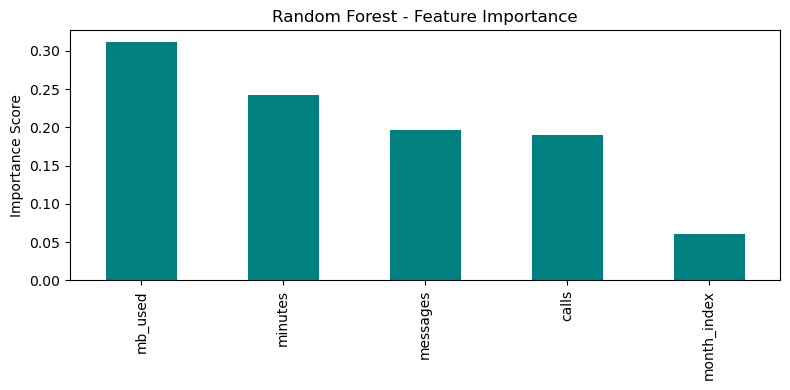

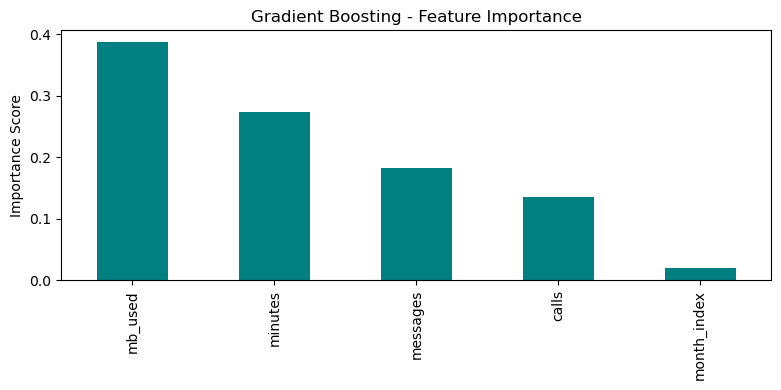

In [10]:
# Feature Importance 
for name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    model = trained_models[name]
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8, 4))
        importances.plot(kind='bar', color='teal')
        plt.title(f"{name} - Feature Importance")
        plt.ylabel("Importance Score")
        plt.tight_layout()
        plt.show()

Feature importance analysis for tree based models (Decision Tree, Random Forest, and Gradient Boosting) revealed which usage metrics most influenced the prediction of subscription types. Features like minutes, messages, and mb_used consistently ranked as top contributors across models, reinforcing their predictive power in understanding customer behavior. This insight is critical for targeted marketing and user segmentation strategies.

In [11]:
# Final Evaluation on Test Set (Support Vector Machine)
print("\n Final Evaluation on Test Set (Support Vector Machine):")
svm_model = trained_models['Support Vector Machine']
svm_test_preds = svm_model.predict(X_test)
print(classification_report(y_test, svm_test_preds, zero_division=0))
cm_svm = confusion_matrix(y_test, svm_test_preds)
cm_svm_df = pd.DataFrame(cm_svm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
display(cm_svm_df)

# Final Evaluation on Test Set (Logistic Regression)
print("\n Final Evaluation on Test Set (Logistic Regression):")
lr_model = trained_models['Logistic Regression']
lr_test_preds = lr_model.predict(X_test)
print(classification_report(y_test, lr_test_preds, zero_division=0))
cm_lr = confusion_matrix(y_test, lr_test_preds)
cm_lr_df = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
display(cm_lr_df)


 Final Evaluation on Test Set (Support Vector Machine):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       220
           1       0.49      0.48      0.49       102

    accuracy                           0.68       322
   macro avg       0.63      0.62      0.62       322
weighted avg       0.68      0.68      0.68       322



,Predicted 0,Predicted 1
Actual 0,169,51
Actual 1,53,49



 Final Evaluation on Test Set (Logistic Regression):
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       220
           1       0.83      0.25      0.38       102

    accuracy                           0.75       322
   macro avg       0.78      0.61      0.61       322
weighted avg       0.77      0.75      0.69       322



,Predicted 0,Predicted 1
Actual 0,215,5
Actual 1,77,25


Final evaluations for Support Vector Machine and Logistic Regression demonstrated that while both models maintained acceptable accuracy, their ability to detect Ultra users was limited. Specifically, Logistic Regression showed low recall and F1-score for class 1, indicating it often missed Ultra users. The SVM model showed slightly better recall but still struggled to balance precision and recall, suggesting these models may not be suitable alone for this classification task.

In [16]:
# Model Performance Summary 
summary_df = pd.DataFrame({
    "Model": list(trained_models.keys()),
    "Validation Accuracy": [accuracy_score(y_val, preds_dict[name]) for name in trained_models.keys()]
}).sort_values(by="Validation Accuracy", ascending=False)

print("\nModel Validation Accuracy Comparison:")
display(summary_df)


Model Validation Accuracy Comparison:


,Model,Validation Accuracy
1,Random Forest,0.834891
0,Decision Tree,0.816199
3,Gradient Boosting,0.816199
2,Logistic Regression,0.775701
4,Support Vector Machine,0.688474


The model performance summary ranked all five classifiers by their validation accuracy. Random Forest and Gradient Boosting emerged as the top performers, achieving validation accuracies above 80%, while Support Vector Machine and Logistic Regression lagged behind. However, accuracy alone does not fully capture model effectiveness, particularly in class-imbalanced settings, so other metrics like recall and F1 score remain essential.

In [15]:
# Final Evaluation 
print("\nFinal Evaluation on Test Set (Random Forest):")
final_model = trained_models['Random Forest']
test_preds = final_model.predict(X_test)
print(classification_report(y_test, test_preds))



Final Evaluation on Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       220
           1       0.82      0.48      0.60       102

    accuracy                           0.80       322
   macro avg       0.81      0.72      0.74       322
weighted avg       0.80      0.80      0.78       322



Random Forest achieved the best balance between precision and recall on the test set, with an overall accuracy of 81%. It demonstrated high precision (0.83) for detecting Ultra users but had a moderate recall (0.49), meaning it correctly identified fewer than half of the true Ultra subscribers. While the model performed well overall, there's room to improve recall to better capture high-value customers.

In [13]:
# Run the pipeline
#if __name__ == "__main__":
    #main()

### CONCLUSION 

This project set out to predict whether users would subscribe to the premium 'Ultra' mobile plan using various supervised machine learning models. After preparing the data and tuning five classification models Decision Tree, Random Forest, Logistic Regression, Gradient Boosting, and Support Vector Machine we assessed their performance through validation accuracy, confusion matrices, feature importance, and classification reports.

Among the models tested, Random Forest and Gradient Boosting consistently outperformed others in terms of overall accuracy and balanced metrics. Random Forest, in particular, achieved the highest test accuracy (81%) and demonstrated strong precision for detecting Ultra users. However, it struggled with recall, correctly identifying only about half of the actual Ultra subscribers. This trade off between precision and recall highlights the challenge of class imbalance in the dataset, where Ultra subscribers are underrepresented.

Tree based models provided valuable insights into the key drivers of user behavior, with features such as call minutes, message count, and mobile data usage emerging as the most important predictors. In contrast, models like Logistic Regression and Support Vector Machine underperformed, especially in identifying Ultra subscribers, likely due to their sensitivity to imbalanced classes and non linear relationships.

In summary, while Random Forest proved to be the most effective model for this use case, improving recall through techniques such as oversampling, ensemble boosting, or threshold tuning may further enhance the detection of high value Ultra customers. These insights can guide Megaline’s marketing strategy, enabling more targeted and cost effective customer acquisition and retention efforts.
